# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\tag{2}
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

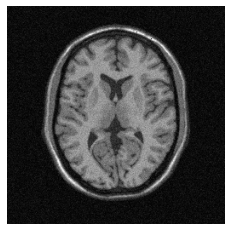

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

#TODO Samodzielna
mat = loadmat("MR_data.mat")
Input = mat['I_noisy1']
plt.imshow(Input.astype("uint8"))
plt.axis("off")
plt.gray()
plt.show()


### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

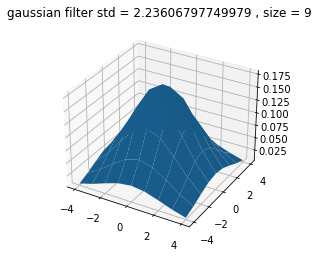

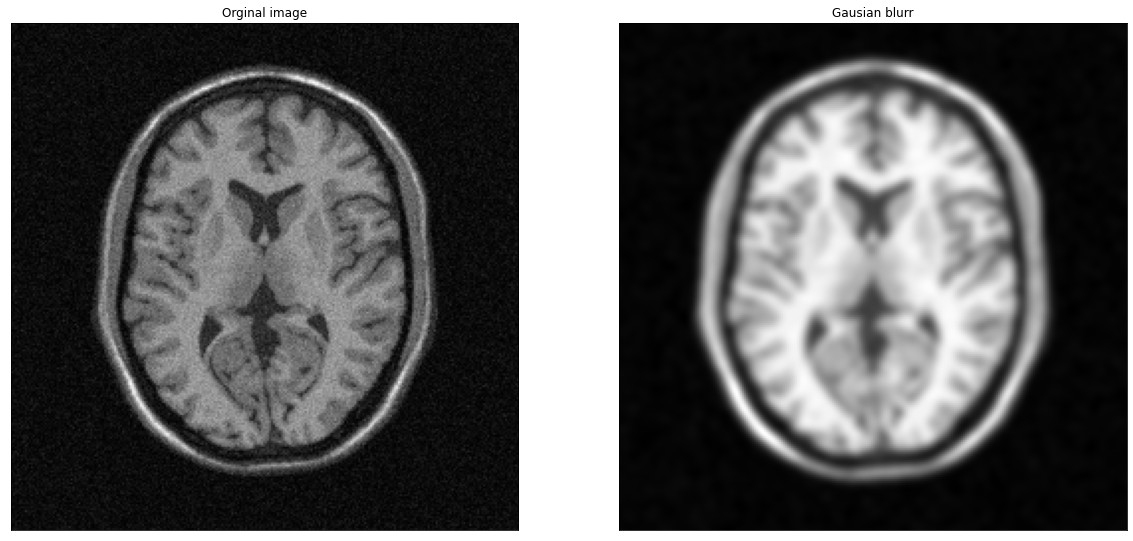

In [21]:
#TODO Samodzielna
def euclidean_norm(*args):
    return np.sqrt(sum([i**2 for i in args]))

def inf_norm(*args):
    args = [abs(i) for i in args]
    return max(args)

def manhatan_norm(*args):
    return np.sum(abs(np.array(args)))

def gauss(x,sigma):
    return (1/(sigma * np.sqrt(2*np.pi)))*np.exp(-(np.power(x,2)/(2*(sigma**2))))

def mesh(fun, size, sigma):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(-size//2 + 1, size//2 + 1, 1)
    Y = np.arange(-size//2 + 1, size//2 + 1, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    ax.plot_surface(X, Y, Z)
    ax.set_title(f"gaussian filter std = {sigma} , size = {size}")
    plt.show()


def classic_convolution(img, size, v, metric = euclidean_norm , show_fillter = False):
    sigma = np.sqrt(v)
    convo = np.array([[gauss(metric(i-size//2,j-size//2),sigma) for j in range(size)] for i in range(size)])
    if show_fillter:mesh(convo,size, sigma)
    res = [[np.sum(img[i-size//2:i+size//2+1, j-size//2:j+size//2+1]*convo)/np.sum(convo) for j in range(size//2,len(img[0])-size//2)] for i in range(size//2, len(img)-size//2)]
    return np.array(res)

classic_convolution(np.zeros([20,20]), 9, 5, show_fillter=True)
IConv = Input.copy()
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,12)
ax[1].imshow(classic_convolution(IConv, 9, 5))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].imshow(Input)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_title("Gausian blurr")
ax[0].set_title("Orginal image")
plt.show()


### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

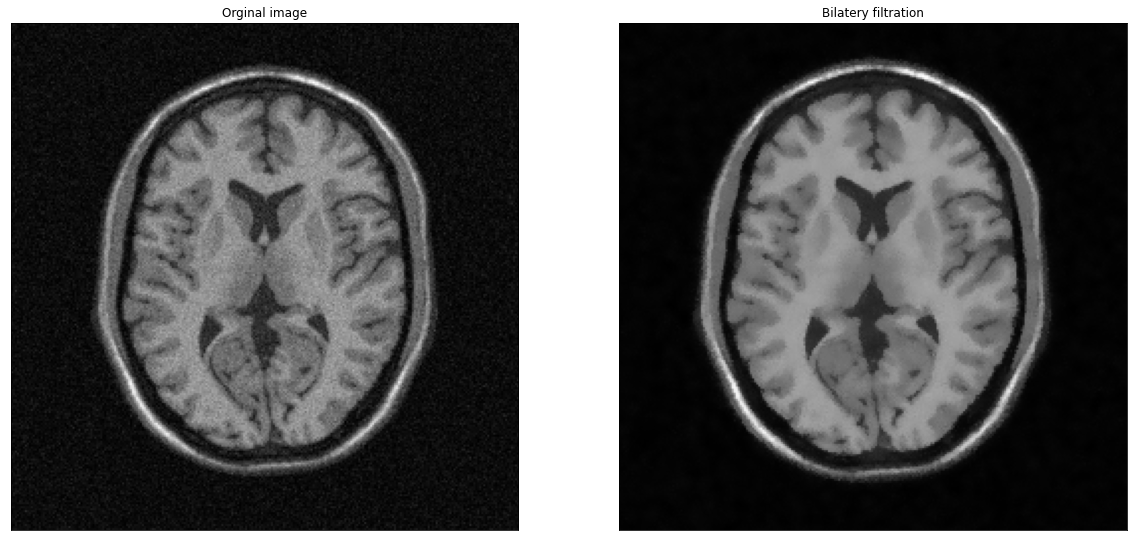

In [23]:
def gamma_func(x,sigma):
    return np.exp(- (np.power(x,2)/(2*sigma**2)))

def Billatery_convolution(img, size, v, sigma_r, metric = euclidean_norm , show_fillter = False):
    sigma = np.sqrt(v)
    convo = np.array([[gauss(metric(i-size//2,j-size//2),sigma) for j in range(size)] for i in range(size)])
    if show_fillter:mesh(convo,size, sigma)
    res = [[np.sum((temp:=img[i-size//2:i+size//2+1, j-size//2:j+size//2+1])*(b:=convo*gamma_func(metric(img[i,j]*np.ones(temp.shape) - temp),sigma_r)))/np.sum(b) for j in range(size//2,len(img[0])-size//2)] for i in range(size//2, len(img)-size//2)]
    return np.array(res)
IBilaterial = Input.copy()
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,12)
ax[1].imshow(Billatery_convolution(IBilaterial, 9, 5, 23))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].imshow(Input)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_title("Bilatery filtration")
ax[0].set_title("Orginal image")
plt.show()